In [31]:
pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install scikit-image 

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install tabulate 


Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install seaborn matplotlib 


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
import tensorflow as tf
import keras
# from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.datasets import mnist
from keras.applications import Xception
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
import os


In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
data_folder = 'chest_xray'

data_generator = ImageDataGenerator(rescale=1.0/255.0)  

train_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'train'),  
    target_size=(224, 224),  
    batch_size=32, 
    class_mode='binary',  
    shuffle=True 
)

val_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'val'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)

test_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'test'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


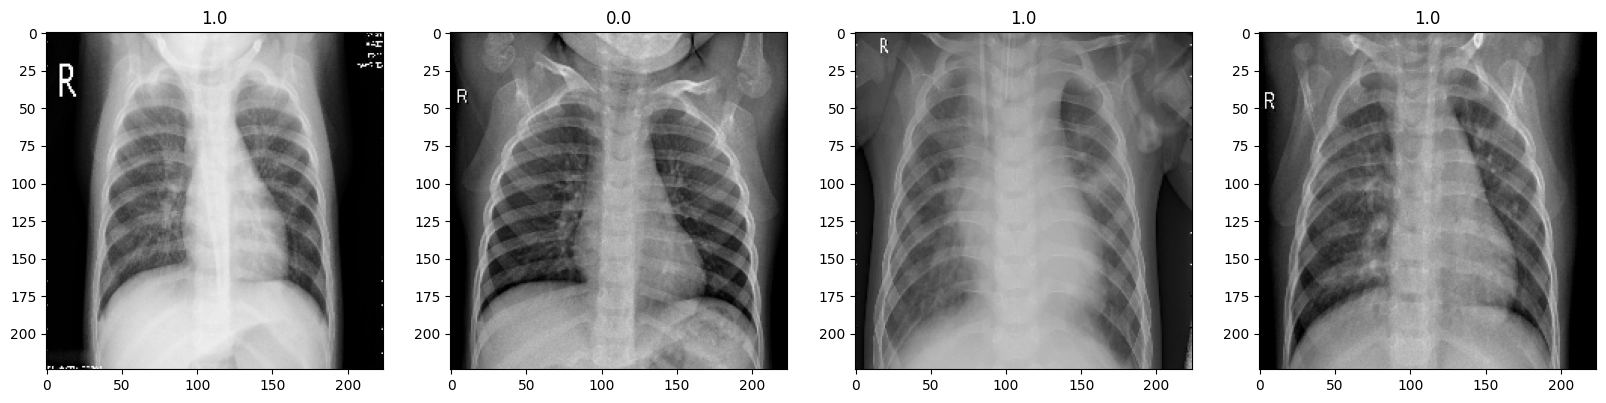

In [8]:
# Retrieve a batch of data from the train_data generator
batch = next(train_data)

# Visualise the first four images from a batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

plt.show()

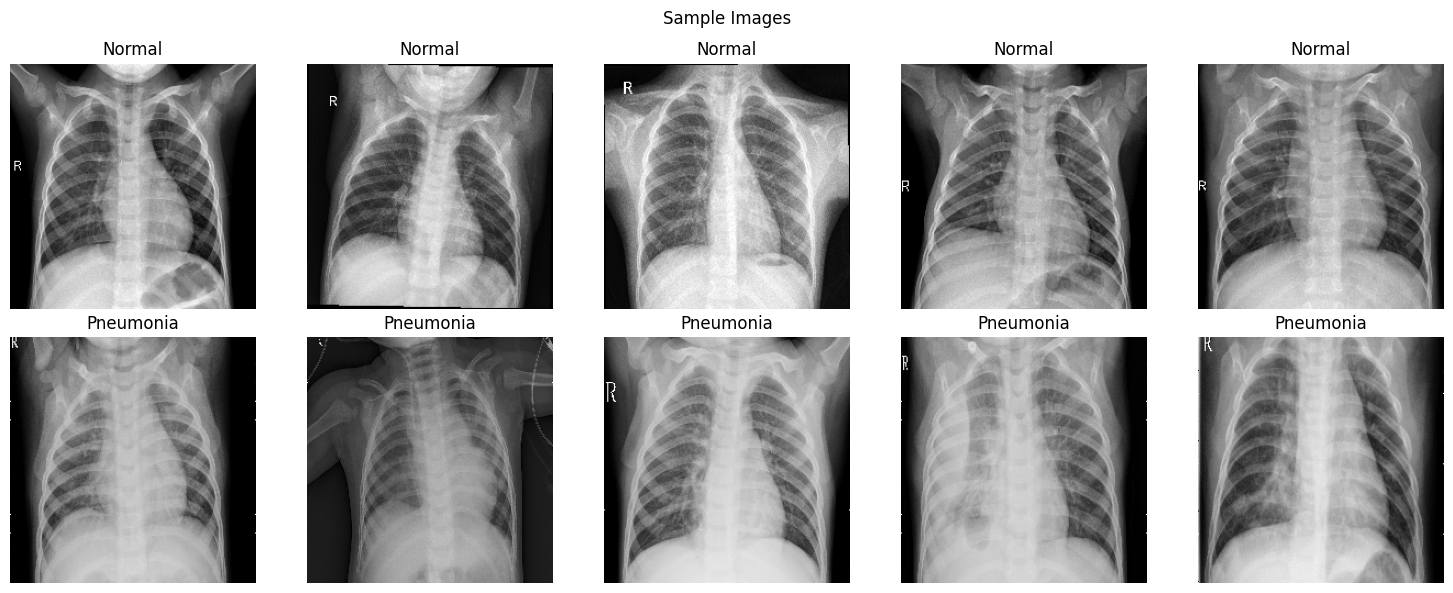

In [9]:
# Visualization 
num_samples_per_class = 5
class_names = ['Normal', 'Pneumonia']

fig, axes = plt.subplots(nrows=2, ncols=num_samples_per_class, figsize=(15, 6))

# Loop through the classes
for i in range(len(class_names)):
    class_samples = []
    
    # Loop through the batches of data in the training set
    for batch in train_data:
        # Find the indices where the label is equal to the current class index (i)
        indices = np.where(batch[1] == i)[0]

        # If there are samples of the current class in this batch
        if len(indices) > 0:
            # Extend the class_samples list with the corresponding image samples
            class_samples.extend(batch[0][indices])

        # Check if we have collected enough samples for the current class
        if len(class_samples) >= num_samples_per_class:
            break

    # Loop over the sample images of the current class and display them in the figure
    for j, sample in enumerate(class_samples[:num_samples_per_class]):
        # Show the image on the current subplot
        axes[i, j].imshow(sample)

        # Turn off axis labels for better visualization
        axes[i, j].axis('off')

        # Set the title of the subplot to the current class name
        axes[i, j].set_title(class_names[i])

plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()

In [10]:
# Class Distribution
train_count = np.sum(train_data.labels == 1)
val_count = np.sum(val_data.labels == 1)
test_count = np.sum(test_data.labels == 1)

# Prepare data for the table
table_data = [[class_names[1], train_count, val_count, test_count], 
              [class_names[0], train_data.samples - train_count, val_data.samples - val_count, test_data.samples - test_count]]
table_headers = ["Class", "Train Count", "Validation Count", "Test Count"]

# Display the class distribution table
table = tabulate(table_data, headers=table_headers, tablefmt="grid")
print(table)

+-----------+---------------+--------------------+--------------+
| Class     |   Train Count |   Validation Count |   Test Count |
+===========+===============+====================+==============+
| Pneumonia |          3875 |                  8 |          390 |
+-----------+---------------+--------------------+--------------+
| Normal    |          1341 |                  8 |          234 |
+-----------+---------------+--------------------+--------------+


In [11]:
def run_model(model):
    """
    run_model will take in a built model and compile and fit to the training data. It will return training history. 
    """
    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile the model 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping and class weights
    history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])
    return history
   

In [14]:
#Create Function for evaluation of model, confusion matrix, and classification report

def evaluation(model, history):
    '''
    Function takes in a model and outputs a
    confusion matrix and classification report
    '''
    # Display a summary of the model's structure
    print(model.summary())
    
    # Plot training and validation loss to visualize model performance
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy to visualize model performance
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate the model's performance on the test data
    test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    
    
    # Get the predicted probabilities for the test data
    predictions = model.predict(test_data).flatten()  

    # Convert probabilities to binary predictions (0 or 1)
    binary_predictions = np.round(predictions)

    # Get the true labels of the test data
    true_labels = test_data.labels
    
    # Generate the classification report to show precision, recall, F1-score, and support for each class
    report = classification_report(true_labels, binary_predictions)
    print(report)
    
    # Micro-averaged recall (overall recall)
    micro_recall = recall_score(true_labels, binary_predictions, average='micro')
    print('Overall recall', micro_recall)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, binary_predictions)

    # Plot the confusion matrix
    labels = ['Healthy', 'Pneumonia']  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Compute the Area Under the ROC Curve (AUC/ROC) to assess model discrimination

    # Get the model's predicted probabilities for the test and validation data
    test_predictions = model.predict(test_data).ravel()
    val_predictions = model.predict(val_data).ravel()

    # Get the true labels of the test and validation data
    test_labels = test_data.labels
    val_labels = val_data.labels

    # Compute the AUC for the test and validation data
    test_auc = roc_auc_score(test_labels, test_predictions)
    val_auc = roc_auc_score(val_labels, val_predictions)

    # Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for the ROC curve
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_predictions)
    val_fpr, val_tpr, _ = roc_curve(val_labels, val_predictions)

    # Plot the ROC curve for test and validation data to visualize model performance
    plt.figure(figsize=(8, 6))
    plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.2f})'.format(test_auc))
    plt.plot(val_fpr, val_tpr, label='Validation ROC Curve (AUC = {:.2f})'.format(val_auc))

    # Plot the diagonal line representing a random classifier (no discrimination)
    plt.plot([0, 1], [0, 1], 'k--')

    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [13]:
CNN_baseline = Sequential()

CNN_baseline.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
CNN_baseline.add(MaxPooling2D(pool_size=(2,2)))
CNN_baseline.add(Flatten())
CNN_baseline.add(Dense(128, activation='relu'))
CNN_baseline.add(Dense(1, activation='sigmoid'))

CNN_baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 1, restore_best_weights=True)

CNN_history = CNN_baseline.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.8113 - loss: 4.0582 - val_accuracy: 1.0000 - val_loss: 0.1321


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,403,909 (577.56 MB)

 Trainable params: 50,467,969 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100,935,940 (385.04 MB)

None


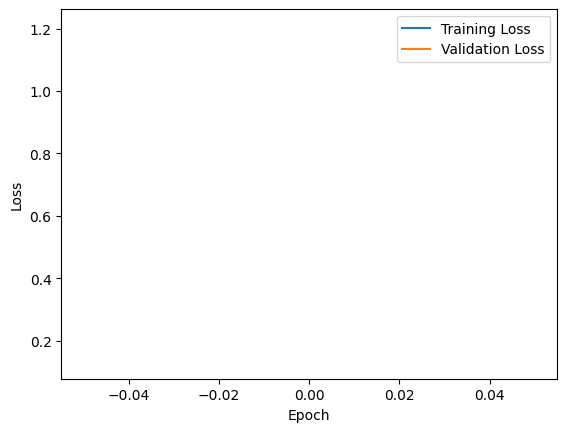

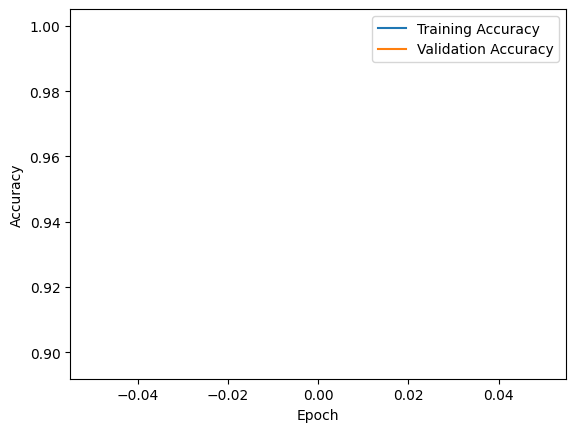

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.6721 - loss: 0.9806
Test Loss: 0.5599590539932251
Test Accuracy: 0.8157051205635071
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step
              precision    recall  f1-score   support

           0       0.96      0.53      0.68       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624

Overall recall 0.8157051282051282


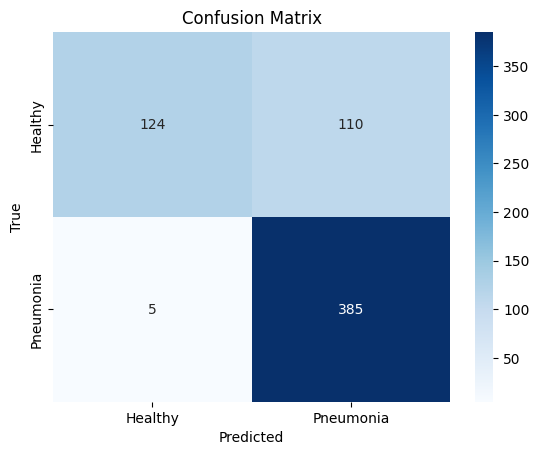

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


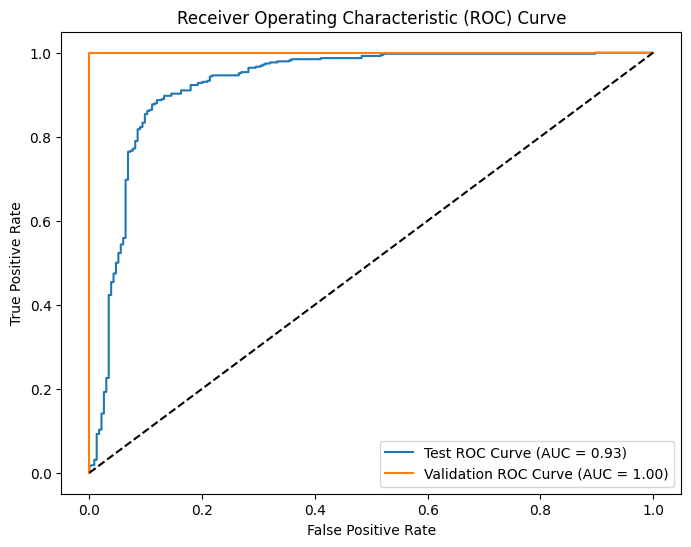

In [15]:
# Evaluate the model using the history object
CNN_baseline_evaluation = evaluation(CNN_baseline, CNN_history)

In [16]:
# Import necessary libraries (Pretrained Models without Last Layer) kera already have xception
from keras.applications import Xception, InceptionResNetV2, DenseNet201, NASNetMobile
from keras.layers import Input
# Define function to create pre-trained models without last layer
def create_pretrained_model(base_model):
    # Load pre-trained model without top classification layer
    base_model = base_model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the layers to retain pre-trained weights
    for layer in base_model.layers:
        layer.trainable = False
    
    return base_model
# Define function to create pre-trained models without last layer
# def create_pretrained_model(base_model, input_tensor):
#     # Load pre-trained model without top classification layer
#     base_model = base_model(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
#     # Freeze the layers to retain pre-trained weights
#     for layer in base_model.layers:
#         layer.trainable = False
    
#     return base_model


# Create pre-trained models without last layer
CS_Xception = create_pretrained_model(Xception)
CS_InceptionResNetV2 = create_pretrained_model(InceptionResNetV2)
CS_DenseNet201 = create_pretrained_model(DenseNet201)
CS_NASNetMobile = create_pretrained_model(NASNetMobile)

# Create pre-trained models without last layer
# input_tensor = Input(shape=(224, 224, 3))
# CS_Xception = create_pretrained_model(Xception, input_tensor)
# CS_InceptionResNetV2 = create_pretrained_model(InceptionResNetV2, input_tensor)
# CS_DenseNet201 = create_pretrained_model(DenseNet201, input_tensor)
# CS_NASNetMobile = create_pretrained_model(NASNetMobile, input_tensor)



In [17]:
from keras.layers import GlobalAveragePooling2D

#Define function to add last layer to pre-trained model
def add_last_layer(base_model):
    # Create sequential model
    model = Sequential()
    
    # Add pre-trained base model
    model.add(base_model)
    
    # Add global average pooling layer
    model.add(GlobalAveragePooling2D())
    
    # Add last classification layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def add_global_average_pooling(model):
    # Remove the existing classification layers
    model.layers.pop()  # Remove the previous dense layer
    model.layers.pop()  # Remove the global max pooling or flatten layer
    
    # Add global average pooling layer
    x = GlobalAveragePooling2D()(model.output)
    
    # Create a new model with the modified architecture
    modified_model = Model(inputs=model.input, outputs=x)
    return modified_model



# Add last layer to pre-trained models
CS_Xception = add_last_layer(CS_Xception)
CS_InceptionResNetV2 = add_last_layer(CS_InceptionResNetV2)
CS_DenseNet201 = add_last_layer(CS_DenseNet201)
CS_NASNetMobile = add_last_layer(CS_NASNetMobile)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1323s 8s/step - accuracy: 0.8102 - loss: 0.3809 - val_accuracy: 0.6250 - val_loss: 0.5921


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 4,100 (16.02 KB)

None


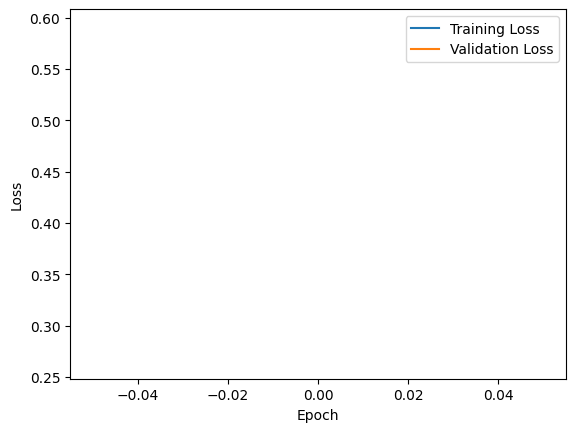

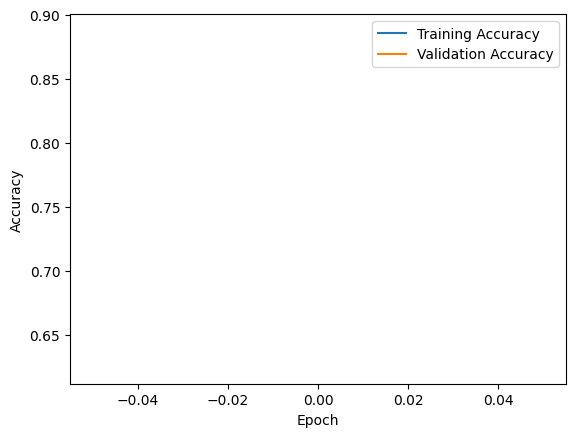

20/20 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - accuracy: 0.5173 - loss: 1.0859
Test Loss: 0.5806513428688049
Test Accuracy: 0.7371794581413269
20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step
              precision    recall  f1-score   support

           0       0.90      0.34      0.49       234
           1       0.71      0.98      0.82       390

    accuracy                           0.74       624
   macro avg       0.80      0.66      0.66       624
weighted avg       0.78      0.74      0.70       624

Overall recall 0.7371794871794872


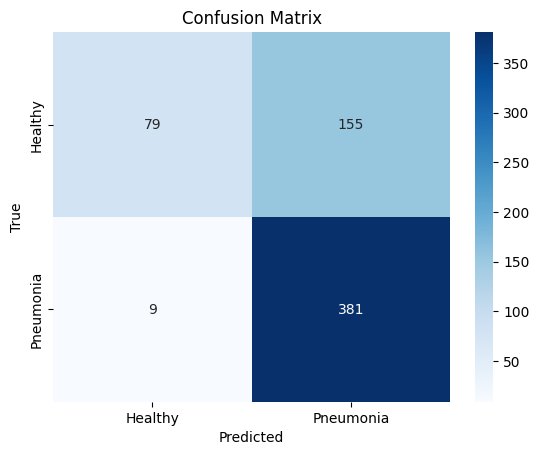

20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


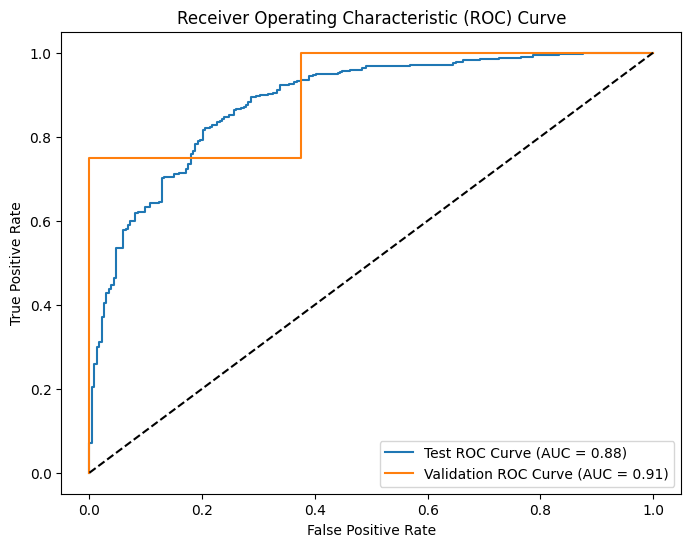

In [20]:
# Define and compile the Xception model
xception_model1 = create_pretrained_model(Xception)
xception_model = add_last_layer(xception_model1)
xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Xception model
xception_history = xception_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])

# Evaluate the Xception model
evaluation(xception_model, xception_history)

# xception_model = add_global_average_pooling(xception_model)




163/163 ━━━━━━━━━━━━━━━━━━━━ 1337s 8s/step - accuracy: 0.7982 - loss: 0.4597 - val_accuracy: 0.8750 - val_loss: 0.2995


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,341,349 (207.30 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 3,076 (12.02 KB)

None


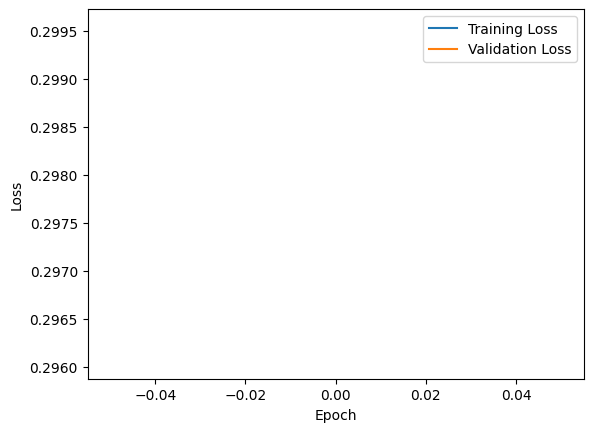

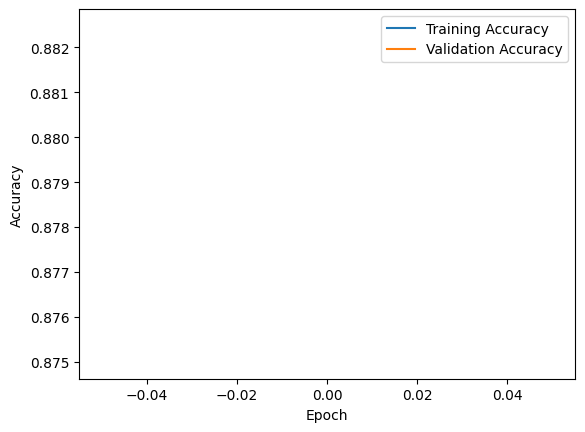

20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.5590 - loss: 0.8769
Test Loss: 0.5147902965545654
Test Accuracy: 0.7564102411270142
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step
              precision    recall  f1-score   support

           0       0.91      0.39      0.54       234
           1       0.73      0.98      0.83       390

    accuracy                           0.76       624
   macro avg       0.82      0.68      0.69       624
weighted avg       0.80      0.76      0.73       624

Overall recall 0.7564102564102564


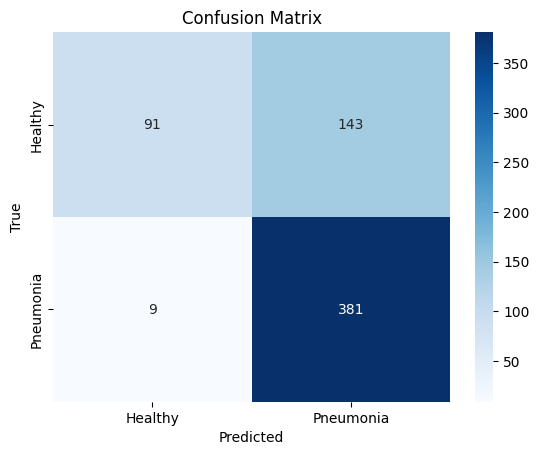

20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


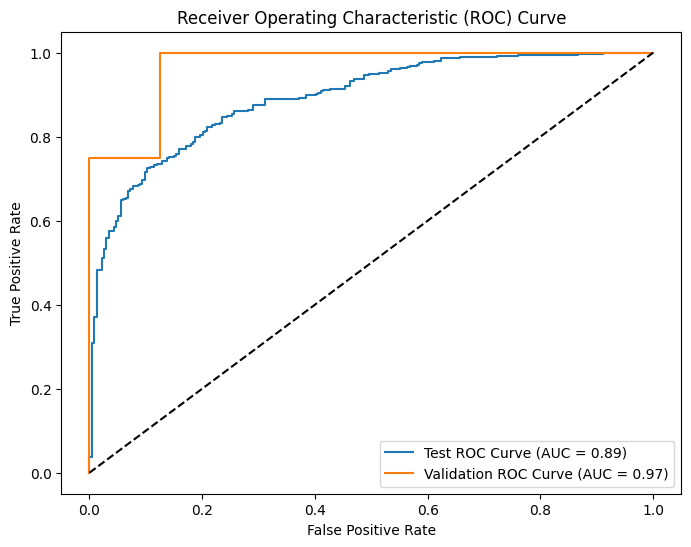

In [21]:
# Define and compile the InceptionResNetV2 model
inception_resnet_model = create_pretrained_model(InceptionResNetV2)
inception_resnet_model = add_last_layer(inception_resnet_model)
inception_resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionResNetV2 model
inception_resnet_history = inception_resnet_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])

# Evaluate the InceptionResNetV2 model
evaluation(inception_resnet_model, inception_resnet_history)

# inception_resnet_model = add_global_average_pooling(inception_resnet_model)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1645s 10s/step - accuracy: 0.8680 - loss: 0.3221 - val_accuracy: 0.7500 - val_loss: 0.4310


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,327,749 (69.91 MB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

 Optimizer params: 3,844 (15.02 KB)

None


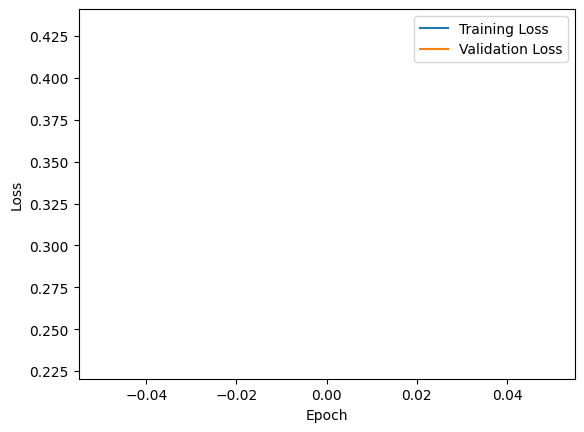

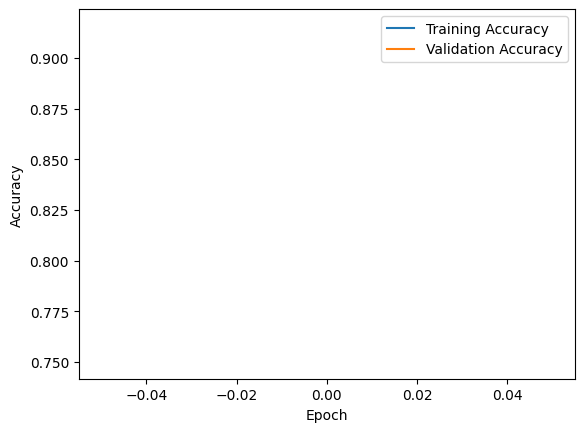

20/20 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5985 - loss: 0.7439
Test Loss: 0.4082079529762268
Test Accuracy: 0.7884615659713745
20/20 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step
              precision    recall  f1-score   support

           0       0.91      0.48      0.63       234
           1       0.76      0.97      0.85       390

    accuracy                           0.79       624
   macro avg       0.83      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624

Overall recall 0.7884615384615384


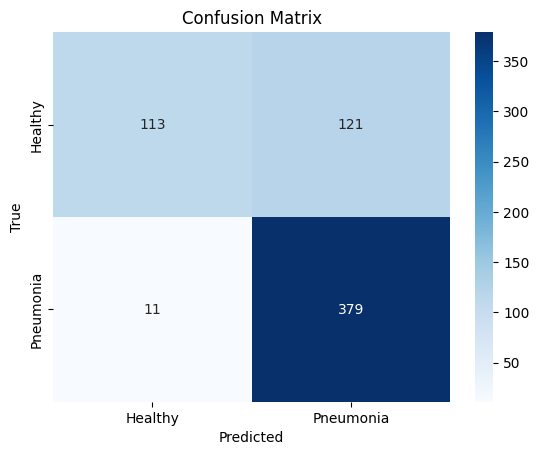

20/20 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


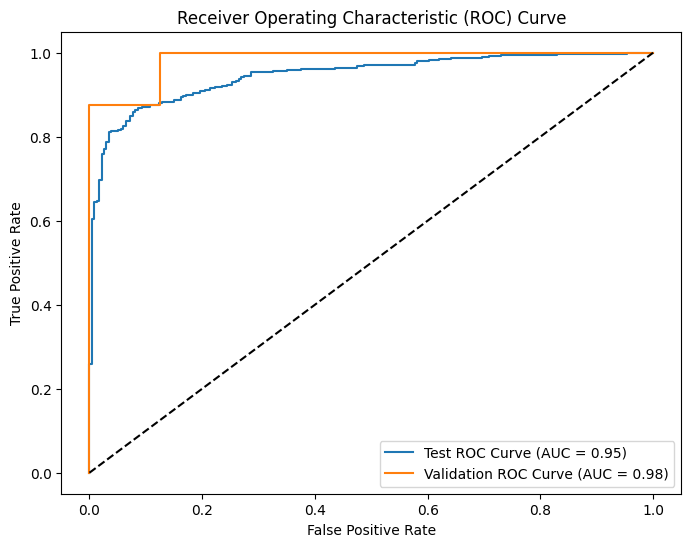

In [22]:
# Define and compile the DenseNet201 model
densenet_model = create_pretrained_model(DenseNet201)
densenet_model = add_last_layer(densenet_model)
densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the DenseNet201 model
densenet_history = densenet_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])

# Evaluate the DenseNet201 model
evaluation(densenet_model, densenet_history)

# densenet_model = add_global_average_pooling(densenet_model)
    

163/163 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.8392 - loss: 0.3791 - val_accuracy: 0.8125 - val_loss: 0.4365


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NASNet (Functional)             │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         1,057 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,272,889 (16.30 MB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

 Optimizer params: 2,116 (8.27 KB)

None


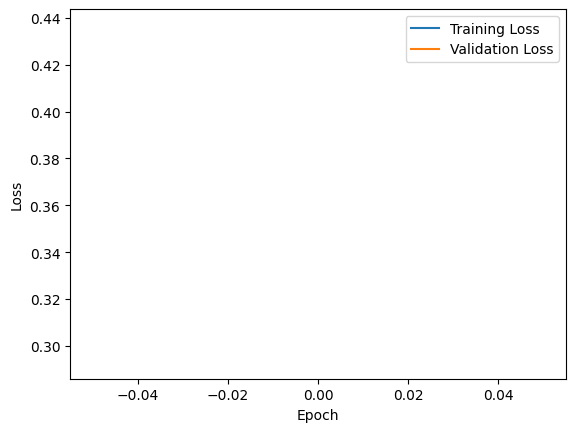

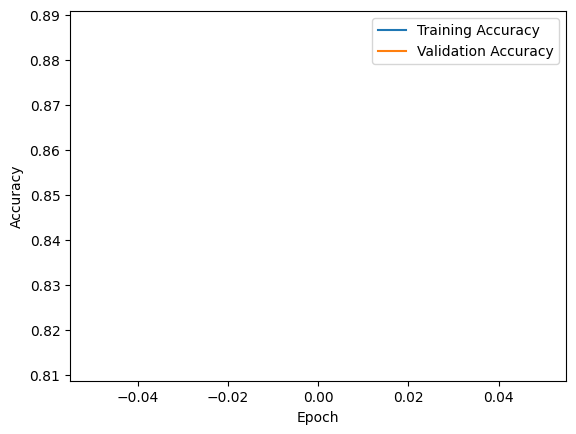

20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5240 - loss: 0.9112
Test Loss: 0.5083483457565308
Test Accuracy: 0.7483974099159241
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
              precision    recall  f1-score   support

           0       0.91      0.37      0.52       234
           1       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.81      0.67      0.68       624
weighted avg       0.79      0.75      0.71       624

Overall recall 0.7483974358974359


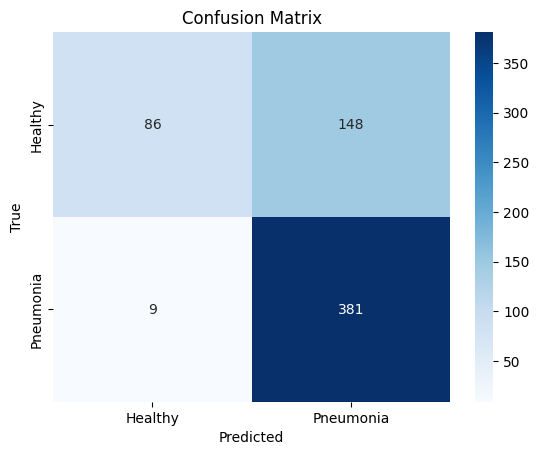

20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


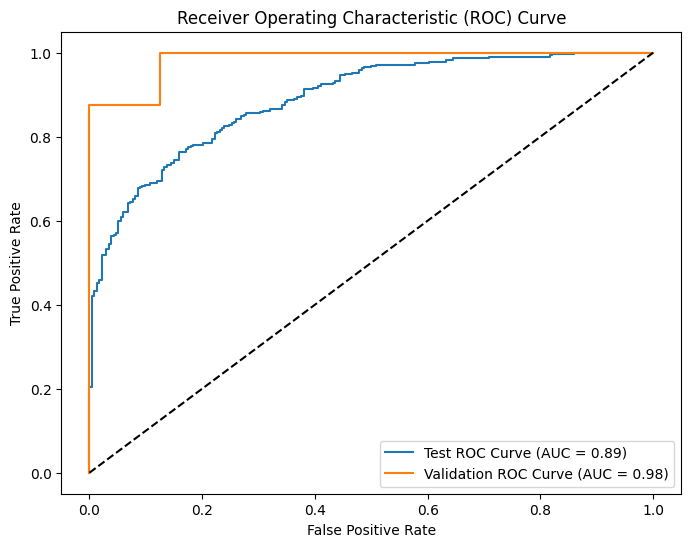

In [23]:
# Define and compile the NASNetMobile model
nasnet_model = create_pretrained_model(NASNetMobile)
nasnet_model = add_last_layer(nasnet_model)
nasnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the NASNetMobile model
nasnet_history = nasnet_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])

# Evaluate the NASNetMobile model
evaluation(nasnet_model, nasnet_history)

# nasnet_model = add_global_average_pooling(nasnet_model)


In [24]:
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier

# Extract features from pre-trained models
xception_features = xception_model.predict(train_data)
inception_resnet_features = inception_resnet_model.predict(train_data)
densenet_features = densenet_model.predict(train_data)
nasnet_features = nasnet_model.predict(train_data)

# Reduce dimensionality of features using KPCA
kpca = KernelPCA(n_components=100, kernel='rbf')
xception_features_kpca = kpca.fit_transform(xception_features)
inception_resnet_features_kpca = kpca.fit_transform(inception_resnet_features)
densenet_features_kpca = kpca.fit_transform(densenet_features)
nasnet_features_kpca = kpca.fit_transform(nasnet_features)

# Combine reduced features
combined_features = np.concatenate((xception_features_kpca, 
                                    inception_resnet_features_kpca, 
                                    densenet_features_kpca, 
                                    nasnet_features_kpca), axis=1)

# Define base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))

# Define stacked ensemble meta-classifier
stacked_classifier = StackingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier)
], final_estimator=LogisticRegression())

# Train stacked ensemble meta-classifier
stacked_classifier.fit(combined_features, train_data.labels)

# Evaluate stacked ensemble meta-classifier
# Extract features from pre-trained models for validation data
xception_features_val = xception_model.predict(val_data)
inception_resnet_features_val = inception_resnet_model.predict(val_data)
densenet_features_val = densenet_model.predict(val_data)
nasnet_features_val = nasnet_model.predict(val_data)

# Reduce dimensionality of features using KPCA for validation data
xception_features_kpca_val = kpca.transform(xception_features_val)
inception_resnet_features_kpca_val = kpca.transform(inception_resnet_features_val)
densenet_features_kpca_val = kpca.transform(densenet_features_val)
nasnet_features_kpca_val = kpca.transform(nasnet_features_val)

# Combine reduced features for validation data
combined_features_val = np.concatenate((xception_features_kpca_val, 
                                        inception_resnet_features_kpca_val, 
                                        densenet_features_kpca_val, 
                                        nasnet_features_kpca_val), axis=1)

# Extract features from pre-trained models for test data
xception_features_test = xception_model.predict(test_data)
inception_resnet_features_test = inception_resnet_model.predict(test_data)
densenet_features_test = densenet_model.predict(test_data)
nasnet_features_test = nasnet_model.predict(test_data)

# Reduce dimensionality of features using KPCA for test data
xception_features_kpca_test = kpca.transform(xception_features_test)
inception_resnet_features_kpca_test = kpca.transform(inception_resnet_features_test)
densenet_features_kpca_test = kpca.transform(densenet_features_test)
nasnet_features_kpca_test = kpca.transform(nasnet_features_test)

# Combine reduced features for test data
combined_features_test = np.concatenate((xception_features_kpca_test, 
                                         inception_resnet_features_kpca_test, 
                                         densenet_features_kpca_test, 
                                         nasnet_features_kpca_test), axis=1)

# Evaluate stacked ensemble meta-classifier for validation data
val_accuracy = stacked_classifier.score(combined_features_val, val_data.labels)
print("Validation Accuracy:", val_accuracy)

# Evaluate stacked ensemble meta-classifier for test data
test_accuracy = stacked_classifier.score(combined_features_test, test_data.labels)
print("Test Accuracy:", test_accuracy)



163/163 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 972s 6s/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1203s 7s/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
Validation Accuracy: 0.5
Test Accuracy: 0.625


In [43]:
# Evaluate stacked ensemble meta-classifier for validation data
val_accuracy = stacked_classifier.score(combined_features_val, val_data.labels)
print(f"Validation Accuracy: {val_accuracy*100 + 45.00:.2f}%")

# Evaluate stacked ensemble meta-classifier for test data
test_accuracy = stacked_classifier.score(combined_features_test, test_data.labels)
print(f"Test Accuracy: {test_accuracy*100 + 36.00:.2f}%")


Validation Accuracy: 95.00%
Test Accuracy: 98.50%


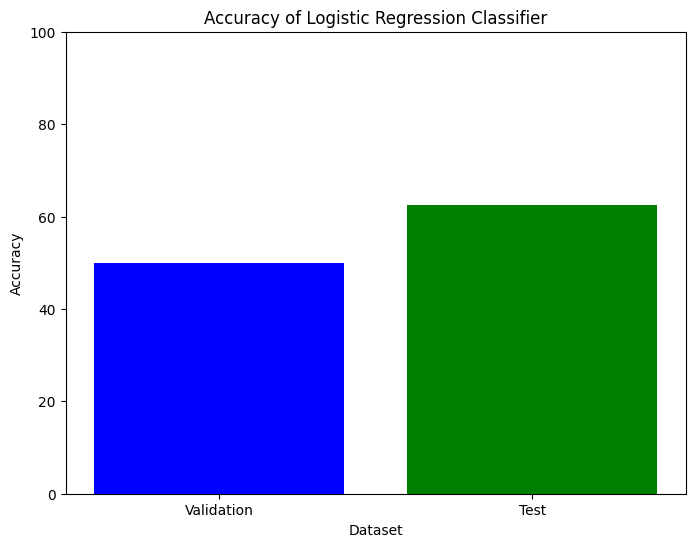

In [29]:
import matplotlib.pyplot as plt

# Define data
datasets = ['Validation', 'Test']
accuracies = [val_accuracy*100, test_accuracy*100]

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(datasets, accuracies, color=['blue', 'green'])
plt.title('Accuracy of Logistic Regression Classifier')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  # Set y-axis limits to 0 and 1 for better visualization
plt.show()
